# Mock Embedding Training

In [1]:
from pennylane import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
sys.path.insert(0, '/Users/tak/Github/QEmbedding/')
import Hybrid_nn
import torch
from torch import nn
import data
import pennylane as qml
import embedding

2023-02-23 21:24:59.568605: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import pennylane as qml
from pennylane import numpy as np
from qiskit import IBMQ
from qiskit.providers.fake_provider import FakeJakarta, FakeMontreal
from qiskit_aer.noise import NoiseModel


noisy = FakeJakarta()
noise_model = NoiseModel.from_backend(noisy)
coupling_map = noisy.configuration().coupling_map
basis_gates = noise_model.basis_gates

dev = qml.device(
    'qiskit.aer',
    wires=4,
    shots=1024,
    noise_model=noise_model,
    coupling_map=coupling_map,
    basis_gates=basis_gates
)

PATH_Model2 = '/Users/tak/Github/QEmbedding/Results/QCNN_demonstration/Real device/Mock/Mock3 (100iter,5batch)/Model2.pt'
PATH_Model3 = '/Users/tak/Github/QEmbedding/Results/QCNN_demonstration/Real device/Mock/Mock3 (100iter,5batch)/Model3.pt'

In [3]:
steps = 100
batch_size = 5

# Model 2

Load the dataset for Model1 and Model2

In [4]:
feature_reduction = 'PCA4'
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)


def new_data(batch_size, X, Y):
    X1_new, X2_new, Y_new = [], [], []
    for i in range(batch_size):
        n, m = np.random.randint(len(X)), np.random.randint(len(X))
        X1_new.append(X[n])
        X2_new.append(X[m])
        if Y[n] == Y[m]:
            Y_new.append(1)
        else:
            Y_new.append(0)

    X1_new, X2_new, Y_new = torch.tensor(X1_new).to(torch.float32), torch.tensor(X2_new).to(torch.float32), torch.tensor(Y_new).to(torch.float32)
    if feature_reduction == False:
        X1_new = X1_new.permute(0, 3, 1, 2)
        X2_new = X2_new.permute(0, 3, 1, 2)
    return X1_new, X2_new, Y_new

2023-02-23 21:25:07.804088: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
@qml.qnode(dev, interface="torch")
def embedding_overlap(inputs):

    for i in range(4):
        qml.Hadamard(wires=i)

    embedding.exp_Z(inputs[0], wires=0)
    embedding.exp_Z(inputs[1], wires=1)
    embedding.exp_Z(inputs[2], wires=2)
    embedding.exp_Z(inputs[3], wires=3)
    
    
    embedding.exp_ZZ1(inputs[4], wires=[0,1])
    embedding.exp_ZZ1(inputs[5], wires=[1,2])
    embedding.exp_ZZ1(inputs[6] - inputs[13], wires=[2,3])
    embedding.exp_ZZ1(-inputs[12], wires=[1,2])
    embedding.exp_ZZ1(-inputs[11], wires=[0,1])

    embedding.exp_Z(-1 * inputs[10], wires=3)
    embedding.exp_Z(-1 * inputs[9], wires=2)
    embedding.exp_Z(-1 * inputs[8], wires=1)
    embedding.exp_Z(-1 * inputs[7], wires=0)

    for i in range(4):
        qml.Hadamard(wires=i)

    return qml.probs(wires=range(4))
    

class Model2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer2 = qml.qnn.TorchLayer(embedding_overlap, weight_shapes={})
        self.linear_relu_stack2 = nn.Sequential(
            nn.Linear(4, 12),
            nn.ReLU(),
            nn.Linear(12, 12),
            nn.ReLU(),
            nn.Linear(12, 7)
        )
    def forward(self, x1, x2):
        x1 = self.linear_relu_stack2(x1)
        x2 = self.linear_relu_stack2(x2)
        x = torch.concat([x1, x2], 1)
        x = self.qlayer2(x)
        return x[:,0]


class Model3(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer3 = qml.qnn.TorchLayer(embedding_overlap, weight_shapes={})
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Layer2: 14 * 14 -> 7 * 7
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected Layers 7 * 7 -> 7
        self.fc = torch.nn.Linear(7 * 7, 7, bias=True)
        
    def forward(self, x1, x2):
        x1 = self.layer1(x1)
        x1 = self.layer2(x1)
        x1 = x1.view(-1, 7 * 7)
        x1 = self.fc(x1)

        x2 = self.layer1(x2)
        x2 = self.layer2(x2)
        x2 = x2.view(-1, 7 * 7)
        x2 = self.fc(x2)

        x = torch.concat([x1, x2], 1)
        x = self.qlayer3(x)
        return x[:,0]

In [6]:
def train_models(model_name):
    train_loss = []
    if model_name == 'Model2':
        model = Model2()
        PATH = PATH_Model2
    elif model_name == 'Model3':
        model = Model3()
        PATH = PATH_Model3

    model.train()

    loss_fn = torch.nn.MSELoss()
    opt = torch.optim.SGD(model.parameters(), lr=0.1)
    for it in range(steps):

        X1_batch, X2_batch, Y_batch = new_data(batch_size, X_train, Y_train)
        X1_batch, X2_batch, Y_batch = X1_batch, X2_batch, Y_batch

        pred = model(X1_batch, X2_batch)
        pred, Y_batch = pred.to(torch.float32), Y_batch.to(torch.float32)
        loss = loss_fn(pred, Y_batch)
        train_loss.append(loss.item())

        opt.zero_grad()
        loss.backward()
        opt.step()
        print(f"Iterations: {it} Loss: {loss.item()}")
    
    torch.save(model.state_dict(), PATH)
    print(plt.plot(range(steps), train_loss))



/var/folders/g3/xz_ycw3d0qdd8s4r2rdd6m940000gn/T/ipykernel_24783/1639352209.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666646991213/work/torch/csrc/utils/tensor_new.cpp:233.)
  X1_new, X2_new, Y_new = torch.tensor(X1_new).to(torch.float32), torch.tensor(X2_new).to(torch.float32), torch.tensor(Y_new).to(torch.float32)


Iterations: 0 Loss: 0.3261232376098633
Iterations: 1 Loss: 0.18064384162425995
Iterations: 2 Loss: 0.20044612884521484
Iterations: 3 Loss: 0.18215465545654297
Iterations: 4 Loss: 0.08197174221277237
Iterations: 5 Loss: 0.2651691436767578
Iterations: 6 Loss: 0.06694240868091583
Iterations: 7 Loss: 0.07137870788574219
Iterations: 8 Loss: 0.2439996749162674
Iterations: 9 Loss: 0.052660368382930756
Iterations: 10 Loss: 0.08703937381505966
Iterations: 11 Loss: 0.05876464769244194
Iterations: 12 Loss: 0.04107952117919922
Iterations: 13 Loss: 0.21752814948558807
Iterations: 14 Loss: 0.053397178649902344
Iterations: 15 Loss: 0.04251270368695259
Iterations: 16 Loss: 0.06378135830163956
Iterations: 17 Loss: 0.0783870667219162
Iterations: 18 Loss: 0.15816879272460938
Iterations: 19 Loss: 0.17639942467212677
Iterations: 20 Loss: 0.04932766035199165
Iterations: 21 Loss: 0.05537834018468857
Iterations: 22 Loss: 0.08393478393554688
Iterations: 23 Loss: 0.00813903845846653
Iterations: 24 Loss: 0.06295

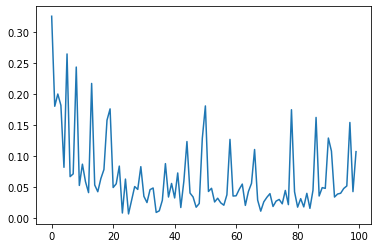

In [7]:
train_models('Model2')

Calculate the distances of Test dataset with the pre-trained quantum embeddings. From the calculated trace distance gain the lower bound of the linear loss function (with respect to the test data).

In [8]:
X1_test, X0_test = [], []
for i in range(len(X_test)):
    if Y_test[i] == 1:
        X1_test.append(X_test[i])
    else:
        X0_test.append(X_test[i])
X1_test, X0_test = torch.tensor(X1_test).to(torch.float32), torch.tensor(X0_test).to(torch.float32)

X1_train, X0_train = [], []
for i in range(len(X_train)):
    if Y_train[i] == 1:
        X1_train.append(X_train[i])
    else:
        X0_train.append(X_train[i])
X1_train, X0_train = torch.tensor(X1_train).to(torch.float32), torch.tensor(X0_train).to(torch.float32)


dev_sim = qml.device('default.qubit', wires=4)
@qml.qnode(dev_sim, interface="torch")
def Noisy_Distance(inputs): 
    embedding.Noisy_Four_QuantumEmbedding2(inputs)
    return qml.density_matrix(wires=range(4))

class Distances2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer2 = qml.qnn.TorchLayer(Noisy_Distance, weight_shapes={})
        self.linear_relu_stack2 = nn.Sequential(
            nn.Linear(4, 12),
            nn.ReLU(),
            nn.Linear(12, 12),
            nn.ReLU(),
            nn.Linear(12, 7)
        )
    def forward(self, x1, x0):
        x1 = self.linear_relu_stack2(x1)
        x0 = self.linear_relu_stack2(x0)
        rhos1 = self.qlayer2(x1)
        rhos0 = self.qlayer2(x0)

        rho1 = torch.sum(rhos1, dim=0) / len(x1)
        rho0 = torch.sum(rhos0, dim=0) / len(x0)
        rho_diff = rho1 - rho0
        eigvals = torch.linalg.eigvals(rho_diff)
        return 0.5 * torch.real(torch.sum(torch.abs(eigvals)))


class Distances3(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer3 = qml.qnn.TorchLayer(Noisy_Distance, weight_shapes={})
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Layer2: 14 * 14 -> 7 * 7
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected Layers 7 * 7 -> 7
        self.fc = torch.nn.Linear(7 * 7, 7, bias=True)
    
    def forward(self, x1, x0):
        x1 = self.layer1(x1)
        x1 = self.layer2(x1)
        x1 = x1.view(-1, 7 * 7)
        x1 = self.fc(x1)

        x0 = self.layer1(x0)
        x0 = self.layer2(x0)
        x0 = x0.view(-1, 7 * 7)
        x0 = self.fc(x0)

        rhos1 = self.qlayer3(x1)
        rhos0 = self.qlayer3(x0)
        
        rho1 = torch.sum(rhos1, dim=0) / len(x1)
        rho0 = torch.sum(rhos0, dim=0) / len(x0)
        rho_diff = rho1 - rho0
        eigvals = torch.linalg.eigvals(rho_diff)
        return 0.5 * torch.real(torch.sum(torch.abs(eigvals)))


Model2_Distance = Distances2()
Model2_Distance.load_state_dict(torch.load(PATH_Model2))

# Calculated from Model1 
Trace_before_traindata = 0.2734867334365845
Trace_before_testdata = 0.2723434865474701

# Distances After training with Model2_HSinner
Trace_Model2_traindata = Model2_Distance(X1_train, X0_train)
Trace_Model2_testdata = Model2_Distance(X1_test, X0_test)

/usr/local/anaconda3/envs/QC/lib/python3.10/site-packages/pennylane/qnn/torch.py:328: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666646991213/work/aten/src/ATen/native/Copy.cpp:250.)
  return self.qnode(**kwargs).type(x.dtype)


# Model 3

In [9]:
feature_reduction = False
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)

Iterations: 0 Loss: 0.5190179944038391
Iterations: 1 Loss: 0.28167399764060974
Iterations: 2 Loss: 0.5380889773368835
Iterations: 3 Loss: 0.3831283450126648
Iterations: 4 Loss: 0.15841007232666016
Iterations: 5 Loss: 0.2910841107368469
Iterations: 6 Loss: 0.5077381134033203
Iterations: 7 Loss: 0.28472423553466797
Iterations: 8 Loss: 0.39202880859375
Iterations: 9 Loss: 0.14251461625099182
Iterations: 10 Loss: 0.5117328763008118
Iterations: 11 Loss: 0.2869560122489929
Iterations: 12 Loss: 0.2792627215385437
Iterations: 13 Loss: 0.5243963003158569
Iterations: 14 Loss: 0.26436957716941833
Iterations: 15 Loss: 0.26958218216896057
Iterations: 16 Loss: 0.5124994516372681
Iterations: 17 Loss: 0.5333715677261353
Iterations: 18 Loss: 0.2843099534511566
Iterations: 19 Loss: 0.5105096697807312
Iterations: 20 Loss: 0.5112363696098328
Iterations: 21 Loss: 0.390756219625473
Iterations: 22 Loss: 0.16308708488941193
Iterations: 23 Loss: 0.14770717918872833
Iterations: 24 Loss: 0.15752753615379333
Iter

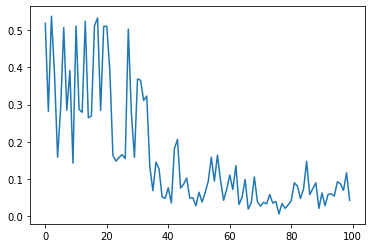

In [10]:
train_models('Model3')

Check the distances after pre-training Noisy Model3 Fidelity

In [11]:
X1_test, X0_test = [], []
for i in range(len(X_test)):
    if Y_test[i] == 1:
        X1_test.append(X_test[i])
    else:
        X0_test.append(X_test[i])
X1_test, X0_test = torch.tensor(X1_test).to(torch.float32), torch.tensor(X0_test).to(torch.float32)
X1_test, X0_test = X1_test.permute(0, 3, 1, 2), X0_test.permute(0, 3, 1, 2)

X1_train, X0_train = [], []
for i in range(len(X_train)):
    if Y_train[i] == 1:
        X1_train.append(X_train[i])
    else:
        X0_train.append(X_train[i])
X1_train, X0_train = torch.tensor(X1_train).to(torch.float32), torch.tensor(X0_train).to(torch.float32)
X1_train, X0_train = X1_train.permute(0, 3, 1, 2), X0_train.permute(0, 3, 1, 2)


Model3_Fidelity_Distance = Distances3()
Model3_Fidelity_Distance.load_state_dict(torch.load(PATH_Model3))


# Distances After training with Model2_Fidelity
Trace_Model3_traindata = Model3_Fidelity_Distance(X1_train, X0_train)
Trace_Model3_testdata = Model3_Fidelity_Distance(X1_test, X0_test)

In [12]:
print("Before Embedding Training\n")
print("-------------------------\n")
print(f"Trace Distance (Training Data) Before: {Trace_before_traindata}")
print(f"Trace Distance (Test Data) Before: {Trace_before_testdata}")
print("\n")
print("After Embedding Training with Model 2\n")
print("-------------------------\n")
print(f"Trace Distance (Training Data) After Noisy Model2 Fidelity: {Trace_Model2_traindata}")
print(f"Trace Distance (Test Data) After Noisy Model2 Fidelity: {Trace_Model2_testdata}")
print("\n")
print("After Embedding Training with Model 3\n")
print("-------------------------\n")
print(f"Trace Distance (Training Data) After Noisy Model3 Fidelity: {Trace_Model3_traindata}")
print(f"Trace Distance (Test Data) After Noisy Model3 Fidelity: {Trace_Model3_testdata}")

Before Embedding Training

-------------------------

Trace Distance (Training Data) Before: 0.2734867334365845
Trace Distance (Test Data) Before: 0.2723434865474701


After Embedding Training with Model 2

-------------------------

Trace Distance (Training Data) After Noisy Model2 Fidelity: 0.6893237829208374
Trace Distance (Test Data) After Noisy Model2 Fidelity: 0.6944125890731812


After Embedding Training with Model 3

-------------------------

Trace Distance (Training Data) After Noisy Model3 Fidelity: 0.7992141246795654
Trace Distance (Test Data) After Noisy Model3 Fidelity: 0.799570620059967
